## Implementing Contrastive Triplet Loss to Improve Classification on Chest X-Rays

By Jess Breda & Claira Fucetola || COS 429 Final Project

This is a downloaded version of the [colab notebook](https://colab.research.google.com/drive/1SurNXBC_GGivpi0qHEhi_qwBMKOS6aIf?usp=sharing) that was used to run all models and generate results in the figures. The code has been organized into submodules for easier viewing, in the code/ subfolder. 



## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset

from sklearn.metrics import confusion_matrix

import seaborn as sns

from efficientnet_pytorch import EfficientNet

import itertools

from online_triplet_loss.losses import *

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
CHEST_MNIST_PATH = '/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/chestmnist.npz'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cuda


## Functions and Classes

In [ ]:
###################################
#           TRANSFORMS            #
###################################

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(
                    num_output_channels=3),
    transforms.Resize((300, 300)),
    transforms.RandomCrop((250, 250)),
    transforms.RandomResizedCrop(32),
    transforms.RandomRotation(degrees=(-5, 5)),
    transforms.RandomAffine(0, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
     ])

identity = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(
                    num_output_channels=3),
    transforms.Resize((32,32)), # we can change this to be whatever size of image we want
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
     ])

In [ ]:
LABELS_DICT = {
    'hernia': [0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    'pleural': [0,0,0,0,0,0,0,0,0,0,0,0,1,0],
    'fibrosis': [0,0,0,0,0,0,0,0,0,0,0,1,0,0],
    'emphysema': [0,0,0,0,0,0,0,0,0,0,1,0,0,0],
    'edema': [0,0,0,0,0,0,0,0,0,1,0,0,0,0],
    'consolidation': [0,0,0,0,0,0,0,0,1,0,0,0,0,0],
    'pneumothorax': [0,0,0,0,0,0,0,1,0,0,0,0,0,0],
    'pneumonia':[0,0,0,0,0,0,1,0,0,0,0,0,0,0],
    'nodule': [0,0,0,0,0,1,0,0,0,0,0,0,0,0],
    'mass': [0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    "infiltration": [0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    'effusion': [0,0,1,0,0,0,0,0,0,0,0,0,0,0],
    'cardiomegaly': [0,1,0,0,0,0,0,0,0,0,0,0,0,0],
    'atelectasis': [1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    'normal': [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
}

In [ ]:
class ChestDataset(Dataset):
    def __init__(self, data, labels, max = None, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        self.indices = []
        N = len(self.data) if max is None else max
        count = 0
        for i in range(N):

            if np.sum(self.labels[i]) > 1 :
                continue
            else:
                self.indices.append(i)
        
    def __len__(self):
        return len(self.indices)
        
    def __getitem__(self, idx):
        x = self.data[self.indices[idx]]
        y = self.labels[self.indices[idx]]


        if self.transforms is not None:
          x = self.transforms(x)
        return x, y

In [ ]:
def getDataset(data, identity, max, split):
  # train data
  train_data = data['train_images']
  train_lab = data['train_labels']

  #test data
  test_data = data['test_images']
  test_lab = data['test_labels']

  #val data
  val_data = data['val_images']
  val_lab = data['val_labels']

  #original dataset (for test and val)
  train_dataset = ChestDataset(train_data, train_lab, max, transforms = identity)
  test_dataset = ChestDataset(test_data, test_lab, max, transforms = identity)
  val_dataset = ChestDataset(val_data, val_lab, max, transforms = identity)

  return train_dataset, test_dataset, val_dataset

In [ ]:
def augmentData(data, transform):
  train_data = data['train_images']
  train_lab = data['train_labels']
  #train_data = data_generator(data)

  # augment the dataset according to transormations
  aug_dataset = ChestDataset(train_data, train_lab, transforms = transform)

  return aug_dataset

In [ ]:
class updateTriplet(Dataset):
    def __init__(self, dataset, triplet, labels, transforms=None):
        self.triplet = triplet #dictonary of anchors and positive and negative indices
        self.dataset = dataset
        self.transforms = transforms
        self.labels = labels
        
    def __len__(self):
        return len(self.dataset)
        
    def __getitem__(self, idx):
        anchor_im, anchor_lab = self.dataset[idx]
        pos, neg = get_triplet(self.dataset, self.triplet, self.labels, anchor_lab)

        # seperate images and labels for each use in and with dataloader
        pos_im, pos_lab = pos
        neg_im, neg_lab = neg
        anchor = (anchor_im, anchor_lab)
        if self.transforms is not None:
          pos_im = self.transforms(pos_im)

        # might want to change what this returns so that it is easy to understand
        # from the dataloader pov
        return anchor_im, pos_im, neg_im

In [ ]:
# return a dictionary of anchors and lists of positive and negative indices 
# given a dataset
def Triplets(dataset, dic, train=True):
  triplets = {}
  labels = []
  for i in range(len(dataset)):
    _, label = dataset[i]
    labels.append(label)
  for i in range(len(dataset)):      
        anchor_img, anchor_label = dataset[i]
        lab = list(filter(lambda x: (dic[x] == anchor_label).all(), dic))[0]

        if lab not in triplets:
            positive_indices = np.where((labels == anchor_label).all(axis=1))[0]
            
            negative_indices = np.where((labels != anchor_label).any(axis=1))[0] # finds where any index doesnt match
   
            
            if len(positive_indices) < 2 or len(negative_indices) < 1:
              continue

            positive_indices = itertools.cycle(positive_indices)
            negative_indices = itertools.cycle(negative_indices)
            triplets.update({lab: (positive_indices, negative_indices)})

        if len(triplets) == 15:
          print("all 15 class labels found")
          break

  return triplets

In [ ]:
# get a random index of a positive image and a negative image given a tripolet 
# of anchor, list in indecies positive, list of indicies negative
def get_triplet(dataset, triplet, label_dic, label):
  # dataset is original dataset

  # get positive and negative indices from label
  lab = list(filter(lambda x: (label_dic[x] == label).all(), label_dic))[0]
  #print(lab)
  positive_indices, negative_indices = triplet[lab]

  # get the next positive image
  positive_idx = next(positive_indices)
  positive_img, positive_label = dataset[positive_idx]

  # get the next negative image
  negative_idx = next(negative_indices)
  negative_img, negative_label = dataset[negative_idx]

  return (positive_img, positive_label), (negative_img, negative_label)

In [ ]:
def triplet_collate(batch):
    # concatenate anchor, positive, and negative tensors
    anchor, positive, negative = zip(*batch) # the way this is written, current anchor, positive, and negative have labels with them but can 
    anchor = torch.stack(anchor, dim=0)
    positive = torch.stack(positive, dim=0)
    negative = torch.stack(negative, dim=0)

    # return triplet tensor
    return torch.stack((anchor, positive, negative), dim=0)

In [ ]:
def balence_data(dataset):
  labels =[]
  for i in range(len(dataset)):
    lab = np.where(dataset[i][1] == 1)[0]
    if lab.size == 0:
        labels.append(0)
    else:
        labels.append(lab[0]+1)

  labels_unique, counts = np.unique(labels, axis =0, return_counts = True)
  class_weights = [sum(counts)/c for c in counts]
  print(class_weights)
  print(labels)
  example_weights = [class_weights[e] for e in labels]
  sampler = WeightedRandomSampler(example_weights, len(labels))

  return sampler

## MODEL

In [ ]:
class MnistModel(nn.Module):
    def __init__(self, mode="contrastive", freeze_features = False):
        super(MnistModel, self).__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )

        # Classification projection head
        self.classification_head = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(p=0.7),
            nn.Linear(256, 15),
            nn.Softmax(dim=1),
        )

        # Contrastive projection head
        self.contrastive_head = nn.Sequential(
            nn.Linear(64 * 4 * 4, 256), nn.ReLU(), nn.Linear(256, 128)
        )
        if freeze_features:
          for param in self.features.parameters():
            param.requires_grad = False
        else:
          for param in self.features.parameters():
            param.requires_grad = True

        self.mode = mode
        print(f"model initialized in {self.mode} mode")

    def forward(self, x):
        h = self.features(x)
        if self.mode == "constrastive":
            z = self.contrastive_head(h)
        else:
            z = self.classification_head(h)
        return h, z


## EfficentNet Model

In [ ]:
class MnistEfficentNetModel(nn.Module):
    def __init__(self, mode="contrastive", freeze_features = False):
        super(MnistModel, self).__init__()

        #transfer learn on efficient net
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')

        # Classification projection head
        self.classification_head = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(p=1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 15),
            nn.Softmax(dim=1)
        )

        # Contrastive projection head
        self.contrastive_head = nn.Sequential(
            nn.Linear(1000, 256), 
            nn.ReLU(inplace=True), 
            #nn.Dropout(p=0.8),
            nn.Linear(256, 128)
        )

        # freeze the feature extraction layers if freeze is True
        if freeze_features:
          for param in self.backbone.parameters():
              param.requires_grad = False
        else:
          # freeze some of the layers and backprop through others
          for i, param in enumerate(self.backbone.parameters()):
            if i < 150:
              param.requires_grad = False
            else:
              param.requires_grad = True

        self.mode = mode
        print(f"model initialized in {self.mode} mode")

    def forward(self, x):
        h = self.backbone(x)
        if self.mode == "constrastive":
            z = self.contrastive_head(h)
        else:
            z = self.classification_head(h)
        return h, z


## Contrastive Train/ Validation

In [ ]:


MODEL_SAVE_PATH = "C:\\Users\\jbred\\github\\med_simCLR\\models\\"


###################################
#              TRAIN              #
###################################

def run_contrastive_training( max_triplets, labels=LABELS_DICT, params={}):
    """
    Primary function for running training of contrastive
    model
    """

    print("loading data")
    data = np.load(CHEST_MNIST_PATH)
    print('Checking data files: ', data.files)
    train_dataset, test_dataset, val_dataset= getDataset(data, identity, max_triplets, False)

    ## TRAIN ##
    #get locations of positive and negative indicies for each anchor label
    print("\nloading train triplet indicies")
    train_triples_idx = Triplets(train_dataset, labels)
    print(f" Train {len(train_triples_idx)} triplet indices")

    #load dataset anchor image (current image in dataset), positive image 
    # (chosen from the list associated with anchors label), negative image
    print('loading train triplets')

    #NOTE: change transforms = transform when doing aug
    train_triplets = updateTriplet(train_dataset, train_triples_idx, labels, transforms = transform)
    print(f"{len(train_triplets)} train triplets")

    ## VAL ##
    #get locations of positive and negative indicies for each anchor label
    print("\n loading val triplet indicies")
    val_triples_idx = Triplets(val_dataset, labels)
    print(f" Train {len(val_triples_idx)} val indices")

    #load dataset anchor image (current image in dataset), positive image 
    # (chosen from the list associated with anchors label), negative image
    print('loading triplets')
    val_triplets = updateTriplet(val_dataset, val_triples_idx, labels)
    print(f"{len(val_triplets)} val triplets\n")


    model = MnistModel(mode="constrastive").to(device)

    data_dict = { 
        "train_dataset" : train_dataset,
        "train_triples_idx" : train_triples_idx,
        "train_triplets" : train_triplets,
        "val_dataset" : val_dataset,
        "val_triples_idx": val_triples_idx,
        "val_triplets" : val_triplets,
        "labels" : labels
    }

    trained_model, train_loss, val_loss = contrastive_train(model, data=data_dict, params=params)

    return trained_model, train_loss, val_loss


def contrastive_train(model, data, params):
    """
    Train function for contrastive triplet loss
    Args:
        model: Object holding the initialized model
        train_set : Containing anchor, anchor label, positive idx, negative idx
        params: Parameters for configuring training
            params["batch_size"]
            params["shuffle_batch"]
            params["learning_rate"]
            params["momentum"]
            params["margin"]
            params["num_epochs"]
        TODO: pass in some sort of test set here as well
    """
    bs = params.get("batch_size", 32)
    sh = params.get("shuffle_batch", True)
    lr = params.get("learning_rate", 0.01)
    mo = params.get("momentum", 0.9)
    mar = params.get("margin", 1.0)
    nep = params.get("num_epochs", 5)
    vb = params.get("verbose", False)
    vf = params.get("val_freq", 5)

    fname = params.get("fname", "saved_model")

    # TODO get embeddings before training stars
    # H_start, _ = model(train_set_anchor_img) # need to store labels to sort H_start too!
    
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/checkpoint_JModelAug.pth') #modified this for my saving purposes
    
    # initalize train_loader from triplets sent in
    # NOTE: change to data[train_dataset] when doing hard trip
    train_loader = torch.utils.data.DataLoader(
        data["train_triplets"], batch_size=bs, shuffle=sh, pin_memory = True
    )
    

    val_loader = torch.utils.data.DataLoader(
        data["val_triplets"],  batch_size=bs, shuffle=sh, 
        collate_fn=triplet_collate, num_workers=0
    )
    
    criterion = nn.TripletMarginLoss(margin=mar, p=2)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = mo)

    train_loss = -99 * np.ones(nep)
    val_loss = 99 * np.ones(int(nep / vf))
    
    # variables for early stopping
    best_val_loss = float('inf')
    patience = 5
    counter = 0
    for ep in range(nep):
        running_loss = 0.0
        train_epoch_loss = 0.0

        #get a new triplets each epoch and reload into dataloader
        #NOTE: Comment this out when doing Hard Trips
        #NOTE: when doing aug, transforms = transform
        shuffled_train_triplets = updateTriplet(data["train_dataset"], data["train_triples_idx"], data["labels"], transforms = transform)
        train_loader = torch.utils.data.DataLoader(
            shuffled_train_triplets, batch_size=bs, shuffle=sh, collate_fn=triplet_collate
        )

        ### TRAIN ###

        #For hard trip i, (im, target)
        # For normal i, (a, p, n)
        for i, (a, p, n) in enumerate(train_loader):

            # forward pass triplets return embedding, projection
            ######################################
            ###         HARD TRIPLETS          ###
            #h, z = model(im.to(device))
            
            #targ_labels = []
  
            #For hard trip only
            #for row in target:
              #lab = np.where(row == 1)[0]
              #if lab.size == 0:
                #targ_labels.append(0)
              #else:
                #targ_labels.append(lab[0]+1)

            #target = torch.tensor(targ_labels)

            
            #########################################

            #for normal trip
            h_a, z_a = model(a.to(device))
            h_p, z_p = model(p.to(device))
            h_n, z_n = model(n.to(device))

            # normalize projections
            z_a = F.normalize(z_a, p=2, dim=1)
            z_p = F.normalize(z_p, p=2, dim=1)
            z_n = F.normalize(z_n, p=2, dim=1)

            # calc loss, backprop, take step
            optimizer.zero_grad()
          
            #normal trip
            batch_loss = criterion(z_a, z_p, z_n)

            #batch_loss = batch_hard_triplet_loss(target.to(device), h, margin=mar)

            batch_loss.backward()
            running_loss += batch_loss.item()
            train_epoch_loss += batch_loss.item()
            optimizer.step()

            # print statistics
            # running_loss += batch_loss.item()
            if vb:
                if i % 100 == 99:  # print every 100 mini-batches
                    print(f"[{ep + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
                    running_loss = 0

        
        train_loss[ep] = train_epoch_loss / len(train_loader)
        print(f"epoch {ep+1}/{nep} complete, loss: {train_epoch_loss / len(train_loader)}")

        ### VALIDATION ###
        ## ASSUMES YOU ARE PASSING THE WHOLE VAL SET IN SINGLE BATCH##
        if (ep+1) % vf == 0:

            # print("entering validation logic")
            
            with torch.no_grad():
                # print("passing through with statement")
                val_running_loss = 0.0
                model.eval()

                ### ISSSUE IS HERE! LEN of val_loader is 1
                # print(f"LEN VAL LOADER {len(val_loader)}")
                for i, (a, p, n) in enumerate(val_loader):

                  # print(f"\n iteration: {i, a.size(), p.size(), n.size()}")
                  h_a, z_a = model(a.to(device))
                  h_p, z_p = model(p.to(device))
                  h_n, z_n = model(n.to(device))

                  z_a = F.normalize(z_a, p=2, dim=1)
                  z_p = F.normalize(z_p, p=2, dim=1)
                  z_n = F.normalize(z_n, p=2, dim=1)

                  # Calculate loss (ASSUME SINGLE BATCH!!)
                  idx = int(((ep + 1) / vf) - 1)
                  val_loss[idx] = criterion(z_a, z_p, z_n).item()
                

                
            print(f"Validation loss: {val_loss[idx]:.3f}")
            model.train()
        
        if ep == 50:
          torch.save(model.state_dict(), "/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/JModelAug_50.pth")
        if ep == 100:
          torch.save(model.state_dict(), "/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/JModelAug_100.pth")
        if ep == 150:
          torch.save(model.state_dict(), "/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/JModelAug_150.pth")
        if ep == 200:
          torch.save(model.state_dict(), "_200.pth")


    print(f"Finished Training!")
    torch.save(model.state_dict(), "/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/end_JModelAug.pth") #modified this for my saving purposes

    # TODO get embeddings after training end
    # H_end, _ = model(train_set_anchor_img) # need to store labels to sort H_start too!

    return model, train_loss, val_loss  # (h_start, h_end)

## RUN Contrastive Training

In [ ]:
params = {
    'batch_size' : 32, 
    'shuffle_batch' : True,
    'learning_rate' : 0.01,
    'momentum' : 0.9,
    'margin' : 0.5, 
    'num_epochs' : 100, 
    'verbose' : False,
    'val_freq' : 5,
    'fname' : 'imgall_bs32_ep300_lr01_mo99_mar2' # name of model
}

In [ ]:
trained_model, train_loss, val_loss = run_contrastive_training(max_triplets=None, params=params)

loading data
Checking data files:  ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']

loading train triplet indicies
all 15 class labels found
 Train 15 triplet indices
loading train triplets
64007 train triplets

 loading val triplet indicies
all 15 class labels found
 Train 15 val indices
loading triplets
9191 val triplets

model initialized in constrastive mode
epoch 1/100 complete, loss: 0.25733790573185084
epoch 2/100 complete, loss: 0.21150499751241222
epoch 3/100 complete, loss: 0.19447975501004813
epoch 4/100 complete, loss: 0.1840618597846227
epoch 5/100 complete, loss: 0.17875836595012315
Validation loss: 0.528
epoch 6/100 complete, loss: 0.17603833081274256
epoch 7/100 complete, loss: 0.17048775224850096
epoch 8/100 complete, loss: 0.17104573656424604
epoch 9/100 complete, loss: 0.16500019405860042
epoch 10/100 complete, loss: 0.16416126679627227
Validation loss: 0.463
epoch 11/100 complete, loss: 0.16208696653317103
epoch 12/100 comp

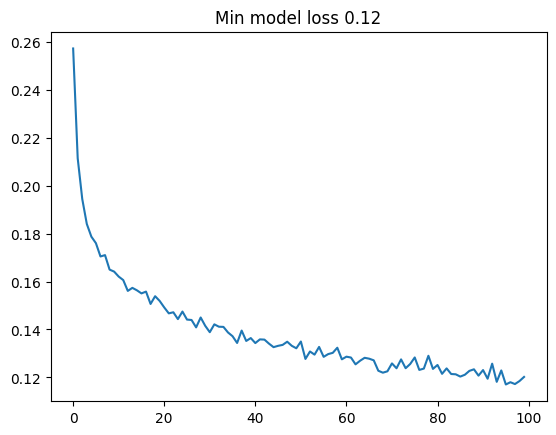

In [ ]:
plt.plot(train_loss)
_ = plt.title(f"Min model loss {np.round(train_loss.min(),2)}")

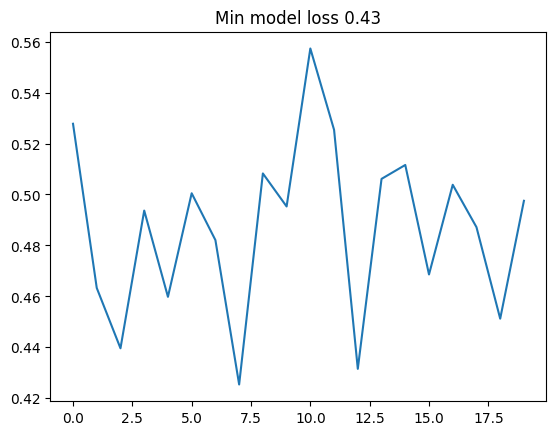

In [ ]:
plt.plot(val_loss)
_ = plt.title(f"Min model loss {np.round(val_loss.min(),2)}")

## Visualize Embeddings

loading data
Checking data files:  ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']
model initialized in contrastive mode
model initialized in contrastive mode


<ipython-input-104-14013518ee19>:79: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(embeddings_before_tsne[:, 0], embeddings_before_tsne[:, 1], c=cmat(norm(pre_train_labels)), cmap='tab10')
<ipython-input-104-14013518ee19>:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[1].scatter(embeddings_after_tsne[:, 0], embeddings_after_tsne[:, 1], c=cmat(norm(post_train_labels)), cmap='tab10')


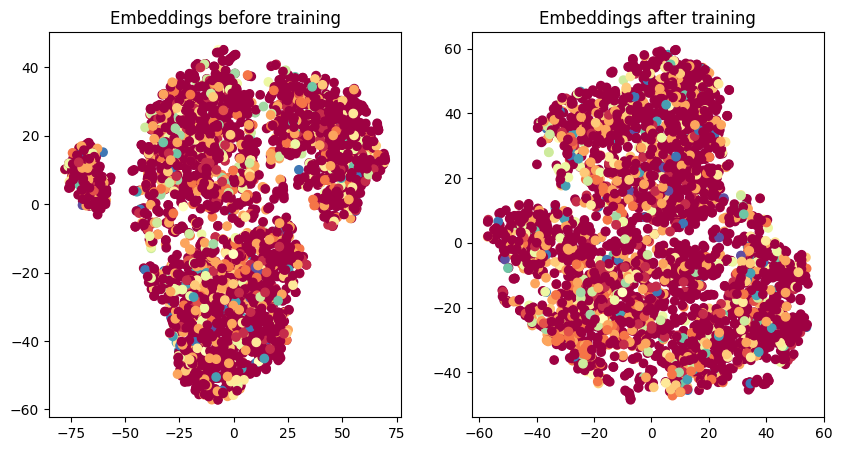

In [ ]:
# Load Data
print("loading data")
data = np.load(CHEST_MNIST_PATH)
print('Checking data files: ', data.files)
train_dataset, test_dataset, val_dataset= getDataset(data, identity, 4000, False)

labels = LABELS_DICT

train_loader = torch.utils.data.DataLoader(
      val_dataset, batch_size=32, shuffle=True,  pin_memory = True
    )

# Get the embeddings before training
with torch.no_grad():
    
    # Load the model's state_dict from the file
    saved_pretrain_state_dict = torch.load('/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/checkpoint_JModelAug.pth')

    # Create a new instance of the model and freeze features
    model_pretrain = MnistModel(freeze_features = True).to(device)

    # Load the saved state_dict into the new model
    model_pretrain.load_state_dict(saved_pretrain_state_dict)
    model_pretrain.mode = 'constrastive'


    model_pretrain.eval()
    embeddings_before = []
    pre_train_labels = []
    for i, (im, lab) in enumerate(train_loader):
        for row in lab:
              lab = np.where(row == 1)[0]
              if lab.size == 0:
                pre_train_labels.append(0)
              else:
                pre_train_labels.append(lab[0]+1)

        h, z = model_pretrain(im.to(device))
        embeddings_before.append(h.cpu())
    embeddings_before = torch.cat(embeddings_before, dim=0)
    
# Get the Embeddings after Training
with torch.no_grad():
    # Load the model's state_dict from the file
    saved_posttrain_state_dict = torch.load("/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/end_JModelAug.pth")

    # Create a new instance of the model
    model_posttrain = MnistModel(freeze_features = True).to(device)

    # Load the saved state_dict into the new model
    model_posttrain.load_state_dict(saved_posttrain_state_dict)


    model_posttrain.mode = 'constrastive'
    model_posttrain.eval()
    embeddings_after = []
    post_train_labels = []
    for i, (im, lab) in enumerate(train_loader):
        for row in lab:
              lab = np.where(row == 1)[0]
              if lab.size == 0:
                post_train_labels.append(0)
              else:
                post_train_labels.append(lab[0]+1)
                
        h, z = model_posttrain(im.to(device))
        embeddings_after.append(h.cpu())
    embeddings_after = torch.cat(embeddings_after, dim=0)

# Reduce the dimensionality of the embeddings with t-SNE
tsne = TSNE(n_components=2)
embeddings_before_tsne = tsne.fit_transform(embeddings_before)
embeddings_after_tsne = tsne.fit_transform(embeddings_after)

# Plot the embeddings
cmat = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=14)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(embeddings_before_tsne[:, 0], embeddings_before_tsne[:, 1], c=cmat(norm(pre_train_labels)), cmap='tab10')
axs[0].set_title('Embeddings before training')
axs[1].scatter(embeddings_after_tsne[:, 0], embeddings_after_tsne[:, 1], c=cmat(norm(post_train_labels)), cmap='tab10')
axs[1].set_title('Embeddings after training')
plt.show()

## Classification Task

In [ ]:
def get_mnist_data_loaders(
    batch_size=32, shuffle=True, train_subset=None, test_subset=None
):

    # load in data
    data = np.load(CHEST_MNIST_PATH)
    # Load the ChestMNIST training dataset
    train_set, test_set, val_set = getDataset(data, identity, max = None, split = False)
    
    #################################################
    ##       BUILDING DATASET WITH AUGMENTATION    ##
    #aug_dataset = augmentData(data, transform)
    #train_set = ConcatDataset([train_set, aug_dataset])
    ##################################################

    if train_subset:
        # Create a subset of the training dataset with the specified number of datapoints
        train_set = Subset(train_set, range(train_subset))
        

  # Balance dataset
    train_sampler = balence_data(train_set)

  # Create a PyTorch DataLoader for the training set
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, sampler = train_sampler
    )


    if test_subset:
        # Create a subset of the validation dataset with the specified number of datapoints
        val_set = Subset(val_set, range(test_subset))

    # Balance dataset
    val_sampler = balence_data(val_set)

    # Create a PyTorch DataLoader for the training set
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, sampler=val_sampler)

    return train_set, train_loader, val_set, val_loader


def run_classification_training(params):
    """
    params: Parameters for configuring training
        params["train_subset]
        params["test_subset]
        params["batch_size"]
        params["shuffle_batch"]
        params["learning_rate"]
        params["momentum"]
        params["num_epochs"]
        params["fname"]
    """

    train_subset = params.get("train_subset", 10000)
    test_subset = params.get("test_subset", 2000)
    bs = params.get("batch_size", 32)
    sh = params.get("shuffle_batch", True)

    _, train_loader, _, test_loader = get_mnist_data_loaders(
        batch_size=bs, train_subset=train_subset, test_subset=test_subset, shuffle=sh
    )
    print(
        f"{len(train_loader.dataset)} train images and {len(test_loader.dataset)} test images loaded"
    )

    #######################################
    ##  LOAD PRETRAINED MODEL           ###
    saved_posttrain_state_dict = torch.load("/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/end_JModel.pth")
    model = MnistModel(mode="classification", freeze_features=True).to(device)
    # Load the saved state_dict into the new model
    model.load_state_dict(saved_posttrain_state_dict)
    ########################################

    ########################################
    ##     FOR NORMAL CLASSIFICATION     ###
    #model = MnistModel(mode = 'classification').to(device)
    ########################################

    trained_model, performance = classification_train(
        train_loader, test_loader, model, params=params
    )

    return trained_model, performance


def classification_train(train_loader, test_loader, model, params):
    # get params
    lr = params.get("learning_rate", 0.01)
    mo = params.get("momentum", 0.9)
    nep = params.get("num_epochs", 5)
    vf = params.get("val_freq", 5)
    fname = params.get("fname", "classification_model")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = mo)

    epoch_train_loss = -99 * np.ones(nep)
    epoch_train_acc = -99 * np.ones(nep)
    epoch_val_loss = -99 * np.ones(int(nep / vf))
    epoch_val_acc = -99 * np.ones(int(nep / vf))

    pre_train_conf_mat = generate_confusion_matrix(model, test_loader)

    ## TRAINING LOOP
    for ep in range(nep):
        # initialize
        train_loss = 0.0
        train_correct = 0

        for data, target in train_loader:
            model.train()  # turn on batch norm layers
            optimizer.zero_grad()  # reset gradients
            _, z = model(data.to(device))  # embedding, softmax
            
            ## Convert labels to digits 0-14 for classification
            targ_labels = []
            for row in target.cpu():
              lab = np.where(row == 1)[0]
              if lab.size == 0:
                targ_labels.append(0)
              else:
                targ_labels.append(lab[0]+1)
            target = torch.tensor(targ_labels).to(device)
            
            loss = criterion(z, target)  # compute loss
            loss.backward()  # calculate gradients
            optimizer.step()  # update weights

            # get predicted label
            pred = z.argmax(dim=1, keepdim=True)

            # update counters
            train_loss += loss.item() * data.size(0)
            train_correct += pred.eq(target.view_as(pred)).sum().item()

        # calculate train summary
        train_loss /= len(train_loader.dataset)  # batch averaged (not summed)
        train_acc = 100.0 * train_correct / len(train_loader.dataset)
        epoch_train_loss[ep] = train_loss
        epoch_train_acc[ep] = train_acc

        print(
            f"Epoch {ep + 1} / {nep} complete, train loss: {train_loss:.6f}, acc: {train_acc:.2f}%"
        )

        # run test
        if (ep + 1) % vf == 0:
            val_loss, val_acc = run_classification_validation(
                test_loader, model, criterion
            )

            # update counters
            idx = int(((ep + 1) / vf) - 1)
            epoch_val_loss[idx] = val_loss
            epoch_val_acc[idx] = val_acc

    print(f"Finished Training!")
    post_train_conf_mat = generate_confusion_matrix(model, test_loader)

    performance = {
        "train_loss": epoch_train_loss,
        "train_acc": epoch_train_acc,
        "val_loss": epoch_val_loss,
        "val_acc": epoch_val_acc,
        "pre_train_conf_mat": pre_train_conf_mat,
        "post_train_conf_mat": post_train_conf_mat,
    }
    torch.save(model.state_dict(),  "/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/end_classificationHardTrip.pth") #modified for my saving

    return model, performance


# def classification_train(train_loader, test_loader, model, params):
#     lr = params.get("learning_rate", 0.01)
#     mo = params.get("momentum", 0.9)
#     nep = params.get("num_epochs", 5)
#     fname = params.get("fname", "classification_model")

#     # compute confusion matrix pre_training


###################################
#              EVAL               #
###################################


def run_classification_validation(test_loader, model, criterion):
    # initialize
    val_loss = 0.0
    val_correct = 0
    model.eval()  # turn off batch norm layers

    # make sure gradients aren't be calculated
    with torch.no_grad():
        for data, target in test_loader:
            # forward pass full test set
            _, z = model(data.to(device))
            #print(target)
            
            # calculate loss
            targ_labels = []
  
            for row in target.cpu():
              lab = np.where(row == 1)[0]
              if lab.size == 0:
                targ_labels.append(0)
              else:
                targ_labels.append(lab[0]+1)

            target = torch.tensor(targ_labels).to(device)
            loss = criterion(z, target)

            # get predicted label
            pred = z.argmax(dim=1, keepdim=True)
            #print(pred)

            # update counters
            val_loss += loss.item() * data.size(0)
            val_correct += pred.eq(target.view_as(pred)).sum().item()

    # calculate validation summary
    val_loss /= len(test_loader.dataset)
    val_acc = 100.0 * val_correct / len(test_loader.dataset)
    print(f"Val Loss: {val_loss:.6f}, Accuracy: {val_acc:.2f}%")

    # TODO- return if you want!
    return val_loss, val_acc


def generate_confusion_matrix(model, test_loader):
    # Set your model to evaluation mode
    model.eval()

    # Disable gradient calculations using torch.no_grad()
    with torch.no_grad():
        # Loop over the test data and perform inference
        y_true = []
        y_hat = []

        for data, target in test_loader:
            # Forward pass
            _, z = model(data.to(device))

            # Compute the predictions
            pred = z.argmax(dim=1)
            
            # Convert labels to 0-14
            targ_labels = []
            for row in target.cpu():
              lab = np.where(row == 1)[0]
              if lab.size == 0:
                targ_labels.append(0)
              else:
                targ_labels.append(lab[0]+1)
            
            # Append the true and predicted labels to the lists
            y_true.append(targ_labels)
            y_hat.append(pred.cpu())

        # Concatenate the lists into arrays
        y_true = np.concatenate(y_true)
        y_hat = np.concatenate(y_hat)

        # Compute the confusion matrix
        conf_mat = confusion_matrix(y_true, y_hat)

    return conf_mat


def plot_confusion_matrix(conf_mat, ax, title="Confusion Matrix"):
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", ax=ax)

    # Set the axis labels and title
    ax.set(xlabel="Predicted Label", ylabel="True Label", title=title)

    return None

## RUN classification

In [ ]:
params = {
    "train_subset" : 3000, # set to None if you want all,max 60k
    "test_subset" : 1000, # max 6k
    "batch_size" : 32,
    "shuffle_batch" : True,
    "learning_rate" : 0.01,
    "momentum" : 0.9,
    'num_epochs' : 50, 
    'val_freq' : 2,
    "fname" : "classification_model"
}

In [ ]:
trained_model, performance = run_classification_training(params)

3000 train images and 1000 test images loaded
model initialized in classification mode
Epoch 1 / 50 complete, train loss: 2.650179, acc: 16.30%
Epoch 2 / 50 complete, train loss: 2.552562, acc: 27.23%
Val Loss: 2.680671, Accuracy: 10.80%
Epoch 3 / 50 complete, train loss: 2.470403, acc: 35.37%
Epoch 4 / 50 complete, train loss: 2.425564, acc: 39.67%
Val Loss: 2.673517, Accuracy: 15.50%
Epoch 5 / 50 complete, train loss: 2.383900, acc: 44.83%
Epoch 6 / 50 complete, train loss: 2.337892, acc: 49.53%
Val Loss: 2.679159, Accuracy: 12.40%
Epoch 7 / 50 complete, train loss: 2.318630, acc: 51.33%
Epoch 8 / 50 complete, train loss: 2.310780, acc: 52.30%
Val Loss: 2.664772, Accuracy: 13.60%
Epoch 9 / 50 complete, train loss: 2.279147, acc: 55.30%
Epoch 10 / 50 complete, train loss: 2.264889, acc: 56.27%
Val Loss: 2.680796, Accuracy: 14.30%
Epoch 11 / 50 complete, train loss: 2.247849, acc: 58.00%
Epoch 12 / 50 complete, train loss: 2.229010, acc: 60.03%
Val Loss: 2.669126, Accuracy: 12.70%
Epoc

In [ ]:
performance.keys()

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'pre_train_conf_mat', 'post_train_conf_mat'])

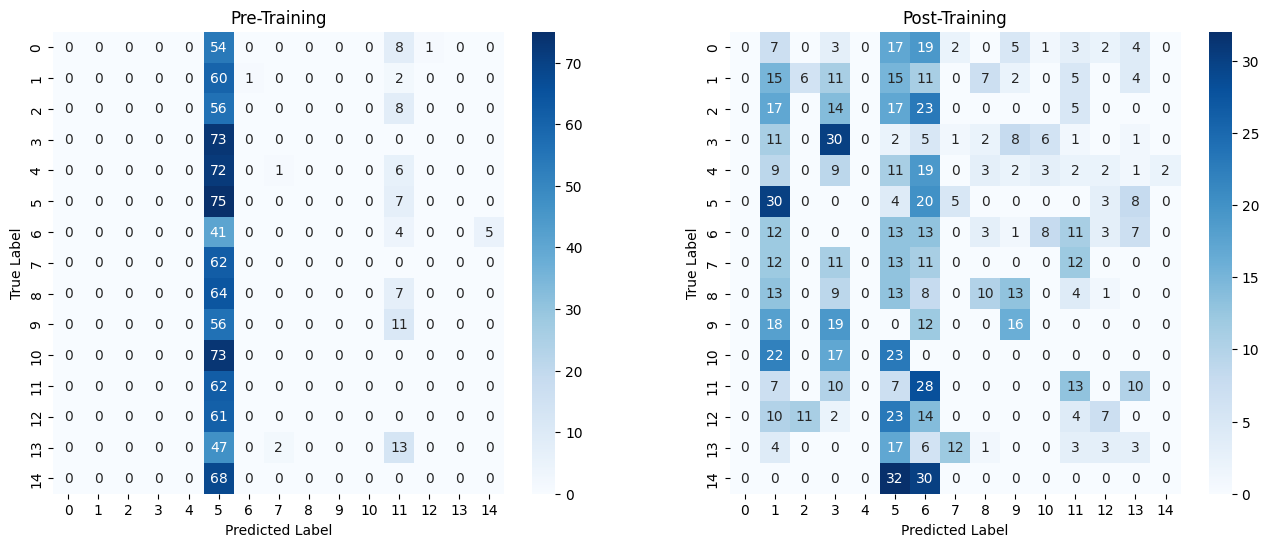

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

plot_confusion_matrix(performance["pre_train_conf_mat"], ax=ax[0], title="Pre-Training")
plot_confusion_matrix(performance["post_train_conf_mat"], ax=ax[1], title="Post-Training")

[Text(0, 0.5, 'Accuracy')]

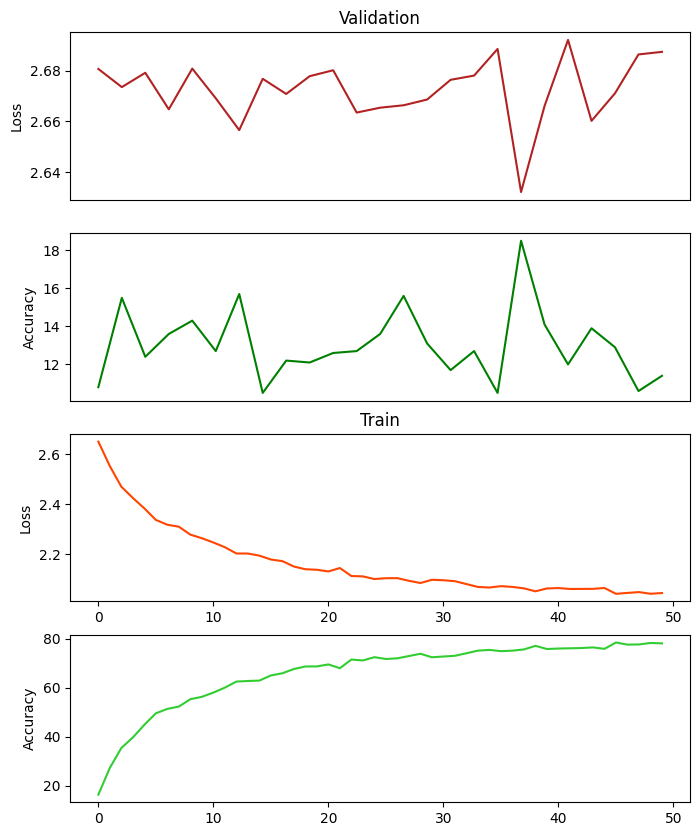

In [ ]:
# ideally would have these on one plot but the lengths 
# are currently different. For train = n epochs. 
# and Val = n epochs/ validation frequency


fig, ax = plt.subplots(4,1, figsize=(8,10))


ax[0].plot(performance["val_loss"], color = "firebrick")
ax[0].set_xticks([])
ax[0].set(title="Validation", ylabel="Loss")

ax[1].plot(performance["val_acc"], color = "green")
ax[1].set_xticks([])
ax[1].set(ylabel="Accuracy")

ax[2].plot(performance["train_loss"], color = "orangered")
ax[2].set(title="Train", ylabel="Loss")


ax[3].plot(performance["train_acc"], color = "limegreen")
ax[3].set(ylabel="Accuracy")

## classification with train set augmented

In [ ]:
def get_mnist_data_loaders(
    batch_size=32, shuffle=True, train_subset=None, test_subset=None
):

    # load in data
    data = np.load(CHEST_MNIST_PATH)
    # Load the ChestMNIST training dataset
    train_set, test_set, val_set = getDataset(data, identity, max = None, split = False)
    
    #################################################
    ##       BUILDING DATASET WITH AUGMENTATION    ##
    aug_dataset = augmentData(data, transform)
    train_set = ConcatDataset([train_set, aug_dataset])
    ##################################################

    if train_subset:
        # Create a subset of the training dataset with the specified number of datapoints
        train_set = Subset(train_set, range(train_subset))
        

  # Balance dataset
    train_sampler = balence_data(train_set)

  # Create a PyTorch DataLoader for the training set
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, sampler = train_sampler
    )


    if test_subset:
        # Create a subset of the training dataset with the specified number of datapoints
        val_set = Subset(val_set, range(test_subset))

    # Balance dataset
    val_sampler = balence_data(val_set)

    # Create a PyTorch DataLoader for the training set
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, sampler=val_sampler)

    return train_set, train_loader, val_set, val_loader


def run_classification_training(params):
    """
    params: Parameters for configuring training
        params["train_subset]
        params["test_subset]
        params["batch_size"]
        params["shuffle_batch"]
        params["learning_rate"]
        params["momentum"]
        params["num_epochs"]
        params["fname"]
    """

    train_subset = params.get("train_subset", 10000)
    test_subset = params.get("test_subset", 2000)
    bs = params.get("batch_size", 32)
    sh = params.get("shuffle_batch", True)

    _, train_loader, _, test_loader = get_mnist_data_loaders(
        batch_size=bs, train_subset=train_subset, test_subset=test_subset, shuffle=sh
    )
    print(
        f"{len(train_loader.dataset)} train images and {len(test_loader.dataset)} test images loaded"
    )

    #######################################
    ##  LOAD PRETRAINED MODEL           ###
    saved_posttrain_state_dict = torch.load("/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/end_JModelAug.pth")
    model = MnistModel(mode="classification", freeze_features=True).to(device)
    # Load the saved state_dict into the new model
    model.load_state_dict(saved_posttrain_state_dict)
    ########################################

    ########################################
    ##     FOR NORMAL CLASSIFICATION     ###
    #model = MnistModel(mode = 'classification').to(device)
    ########################################

    trained_model, performance = classification_train(
        train_loader, test_loader, model, params=params
    )

    return trained_model, performance


def classification_train(train_loader, test_loader, model, params):
    # get params
    lr = params.get("learning_rate", 0.01)
    mo = params.get("momentum", 0.9)
    nep = params.get("num_epochs", 5)
    vf = params.get("val_freq", 5)
    fname = params.get("fname", "classification_model")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = mo)

    epoch_train_loss = -99 * np.ones(nep)
    epoch_train_acc = -99 * np.ones(nep)
    epoch_val_loss = -99 * np.ones(int(nep / vf))
    epoch_val_acc = -99 * np.ones(int(nep / vf))

    pre_train_conf_mat = generate_confusion_matrix(model, test_loader)

    ## TRAINING LOOP
    for ep in range(nep):
        # initialize
        train_loss = 0.0
        train_correct = 0

        for data, target in train_loader:
            model.train()  # turn on batch norm layers
            optimizer.zero_grad()  # reset gradients
            _, z = model(data.to(device))  # embedding, softmax
            
            ## Convert labels to digits 0-14 for classification
            targ_labels = []
            for row in target.cpu():
              lab = np.where(row == 1)[0]
              if lab.size == 0:
                targ_labels.append(0)
              else:
                targ_labels.append(lab[0]+1)
            target = torch.tensor(targ_labels).to(device)
            
            loss = criterion(z, target)  # compute loss
            loss.backward()  # calculate gradients
            optimizer.step()  # update weights

            # get predicted label
            pred = z.argmax(dim=1, keepdim=True)

            # update counters
            train_loss += loss.item() * data.size(0)
            train_correct += pred.eq(target.view_as(pred)).sum().item()

        # calculate train summary
        train_loss /= len(train_loader.dataset)  # batch averaged (not summed)
        train_acc = 100.0 * train_correct / len(train_loader.dataset)
        epoch_train_loss[ep] = train_loss
        epoch_train_acc[ep] = train_acc

        print(
            f"Epoch {ep + 1} / {nep} complete, train loss: {train_loss:.6f}, acc: {train_acc:.2f}%"
        )

        # run test
        if (ep + 1) % vf == 0:
            val_loss, val_acc = run_classification_validation(
                test_loader, model, criterion
            )

            # update counters
            idx = int(((ep + 1) / vf) - 1)
            epoch_val_loss[idx] = val_loss
            epoch_val_acc[idx] = val_acc

    print(f"Finished Training!")
    post_train_conf_mat = generate_confusion_matrix(model, test_loader)

    performance = {
        "train_loss": epoch_train_loss,
        "train_acc": epoch_train_acc,
        "val_loss": epoch_val_loss,
        "val_acc": epoch_val_acc,
        "pre_train_conf_mat": pre_train_conf_mat,
        "post_train_conf_mat": post_train_conf_mat,
    }
    torch.save(model.state_dict(),  "/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/end_augclassification150.pth") #modified for my saving

    return model, performance


# def classification_train(train_loader, test_loader, model, params):
#     lr = params.get("learning_rate", 0.01)
#     mo = params.get("momentum", 0.9)
#     nep = params.get("num_epochs", 5)
#     fname = params.get("fname", "classification_model")

#     # compute confusion matrix pre_training


###################################
#              EVAL               #
###################################


def run_classification_validation(test_loader, model, criterion):
    # initialize
    val_loss = 0.0
    val_correct = 0
    model.eval()  # turn off batch norm layers

    # make sure gradients aren't be calculated
    with torch.no_grad():
        for data, target in test_loader:
            # forward pass full test set
            _, z = model(data.to(device))
            #print(target)
            
            # calculate loss
            targ_labels = []
  
            for row in target.cpu():
              lab = np.where(row == 1)[0]
              if lab.size == 0:
                targ_labels.append(0)
              else:
                targ_labels.append(lab[0]+1)

            target = torch.tensor(targ_labels).to(device)
            loss = criterion(z, target)

            # get predicted label
            pred = z.argmax(dim=1, keepdim=True)
            #print(pred)

            # update counters
            val_loss += loss.item() * data.size(0)
            val_correct += pred.eq(target.view_as(pred)).sum().item()

    # calculate validation summary
    val_loss /= len(test_loader.dataset)
    val_acc = 100.0 * val_correct / len(test_loader.dataset)
    print(f"Val Loss: {val_loss:.6f}, Accuracy: {val_acc:.2f}%")

    # TODO- return if you want!
    return val_loss, val_acc


def generate_confusion_matrix(model, test_loader):
    # Set your model to evaluation mode
    model.eval()

    # Disable gradient calculations using torch.no_grad()
    with torch.no_grad():
        # Loop over the test data and perform inference
        y_true = []
        y_hat = []

        for data, target in test_loader:
            # Forward pass
            _, z = model(data.to(device))

            # Compute the predictions
            pred = z.argmax(dim=1)
            
            # Convert labels to 0-14
            targ_labels = []
            for row in target.cpu():
              lab = np.where(row == 1)[0]
              if lab.size == 0:
                targ_labels.append(0)
              else:
                targ_labels.append(lab[0]+1)
            
            # Append the true and predicted labels to the lists
            y_true.append(targ_labels)
            y_hat.append(pred.cpu())

        # Concatenate the lists into arrays
        y_true = np.concatenate(y_true)
        y_hat = np.concatenate(y_hat)

        # Compute the confusion matrix
        conf_mat = confusion_matrix(y_true, y_hat)

    return conf_mat


def plot_confusion_matrix(conf_mat, ax, title="Confusion Matrix"):
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", ax=ax)

    # Set the axis labels and title
    ax.set(xlabel="Predicted Label", ylabel="True Label", title=title)

    return None

In [ ]:
params = {
    "train_subset" : None, # set to None if you want all,max 60k
    "test_subset" : None, # max 6k
    "batch_size" : 32,
    "shuffle_batch" : True,
    "learning_rate" : 0.01,
    "momentum" : 0.90,
    'num_epochs' : 100, 
    'val_freq' : 2,
    "fname" : "classification_model"
}

In [ ]:
trained_model, performance = run_classification_training(params)

128014 train images and 18187 test images loaded
model initialized in classification mode
Epoch 1 / 100 complete, train loss: 2.671280, acc: 12.81%
Epoch 2 / 100 complete, train loss: 2.650841, acc: 15.13%
Val Loss: 2.638303, Accuracy: 16.96%
Epoch 3 / 100 complete, train loss: 2.640712, acc: 16.24%
Epoch 4 / 100 complete, train loss: 2.629930, acc: 17.41%
Val Loss: 2.633471, Accuracy: 16.46%
Epoch 5 / 100 complete, train loss: 2.623913, acc: 18.10%
Epoch 6 / 100 complete, train loss: 2.620574, acc: 18.43%
Val Loss: 2.626439, Accuracy: 17.79%
Epoch 7 / 100 complete, train loss: 2.615058, acc: 19.04%
Epoch 8 / 100 complete, train loss: 2.612271, acc: 19.31%
Val Loss: 2.625771, Accuracy: 17.84%
Epoch 9 / 100 complete, train loss: 2.605554, acc: 20.05%
Epoch 10 / 100 complete, train loss: 2.603343, acc: 20.28%
Val Loss: 2.620726, Accuracy: 18.60%
Epoch 11 / 100 complete, train loss: 2.600218, acc: 20.62%
Epoch 12 / 100 complete, train loss: 2.596679, acc: 21.06%
Val Loss: 2.616413, Accura

In [ ]:
performance.keys()

dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'pre_train_conf_mat', 'post_train_conf_mat'])

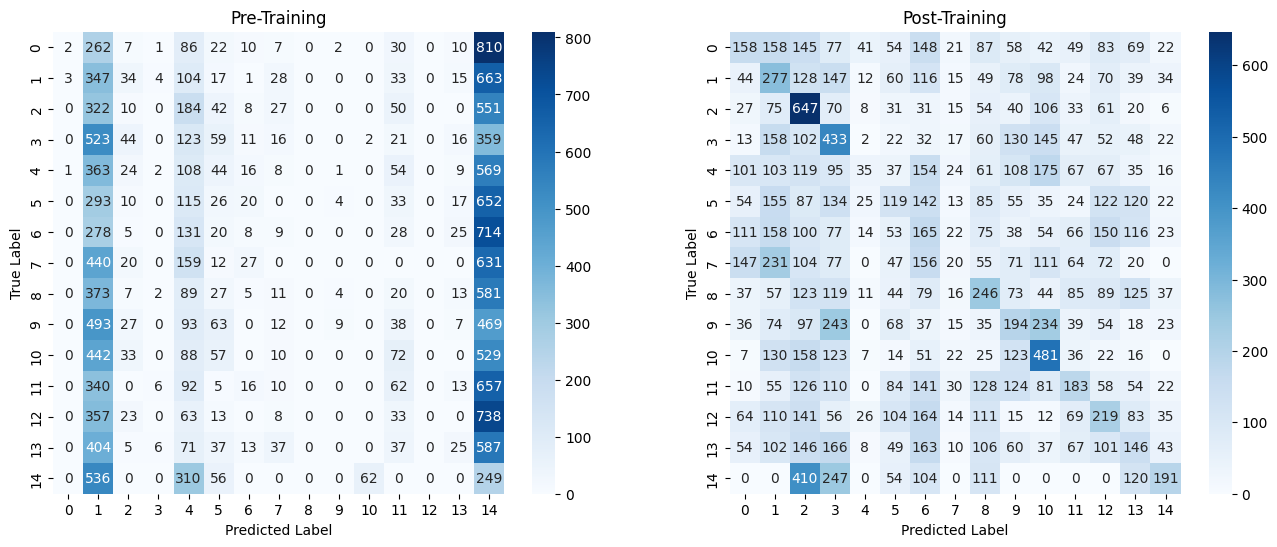

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

plot_confusion_matrix(performance["pre_train_conf_mat"], ax=ax[0], title="Pre-Training")
plot_confusion_matrix(performance["post_train_conf_mat"], ax=ax[1], title="Post-Training")

[Text(0, 0.5, 'Accuracy')]

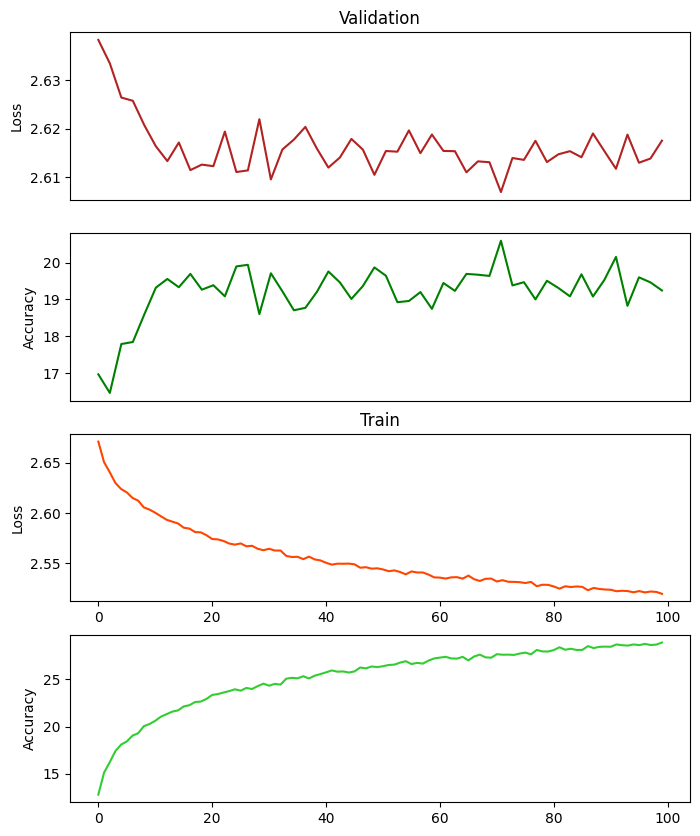

In [ ]:
# ideally would have these on one plot but the lengths 
# are currently different. For train = n epochs. 
# and Val = n epochs/ validation frequency


fig, ax = plt.subplots(4,1, figsize=(8,10))


ax[0].plot(performance["val_loss"], color = "firebrick")
ax[0].set_xticks([])
ax[0].set(title="Validation", ylabel="Loss")

ax[1].plot(performance["val_acc"], color = "green")
ax[1].set_xticks([])
ax[1].set(ylabel="Accuracy")

ax[2].plot(performance["train_loss"], color = "orangered")
ax[2].set(title="Train", ylabel="Loss")


ax[3].plot(performance["train_acc"], color = "limegreen")
ax[3].set(ylabel="Accuracy")

## AUC and Top-1/Top-5 (load in models respectively)

In [ ]:
import torch
from torchvision import transforms, datasets

# Load the model
saved_posttrain_state_dict = torch.load("/content/gdrive/MyDrive/Classes/Spring 2023/COS 429/final_project/end_classificationHardTrip.pth")
model = MnistModel(mode="classification", freeze_features=True)
    # Load the saved state_dict into the new model
model.load_state_dict(saved_posttrain_state_dict)






model initialized in classification mode


<All keys matched successfully>

In [ ]:
from torch.utils.data import DataLoader

# load in data
data = np.load(CHEST_MNIST_PATH)
    # Load the ChestMNIST training dataset
train_set, test_set, val_set = getDataset(data, identity, max = None, split = False)
    # Balance dataset
test_sampler = balence_data(test_set)

    # Create a PyTorch DataLoader for the training set
test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=32, sampler=test_sampler)


# Evaluate the model on the test dataset
model.eval()
with torch.no_grad():
    all_probs = []
    all_labels = []
    for inputs, labels in test_loader:
        _, outputs = model(inputs)
        # Convert labels to 0-14
        #pred = outputs.argmax(dim=0)
        targ_labels = []
        for row in labels:
            lab = np.where(row == 1)[0]
            if lab.size == 0:
              targ_labels.append(0)
            else:
              targ_labels.append(lab[0]+1)

        targ_labels = torch.tensor(targ_labels)
        all_probs.append(outputs)
        all_labels.append(targ_labels)

# Concatenate the predicted probabilities for all batches
all_probs = torch.cat(all_probs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate the AUC for each class
auc_scores = []
print(all_probs.shape)
print(all_labels.shape)

# Reshape the input arrays
#all_probs = all_probs.reshape(-1, 1)
#all_labels= all_labels.reshape(-1, 1)

for i in range(15):
    auc = roc_auc_score((all_labels == i).numpy(), all_probs[:, i].numpy())
    auc_scores.append(auc)

for i, auc in enumerate(auc_scores):
    print(f'Class {i}: AUC = {auc:.4f}')

torch.Size([18187, 15])
torch.Size([18187])
Class 0: AUC = 0.4965
Class 1: AUC = 0.5160
Class 2: AUC = 0.5182
Class 3: AUC = 0.5095
Class 4: AUC = 0.4654
Class 5: AUC = 0.5101
Class 6: AUC = 0.5214
Class 7: AUC = 0.5202
Class 8: AUC = 0.5148
Class 9: AUC = 0.4913
Class 10: AUC = 0.5659
Class 11: AUC = 0.4639
Class 12: AUC = 0.5568
Class 13: AUC = 0.4877
Class 14: AUC = 0.5158


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(all_probs.shape[1]):
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).numpy(), all_probs[:, i].numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])

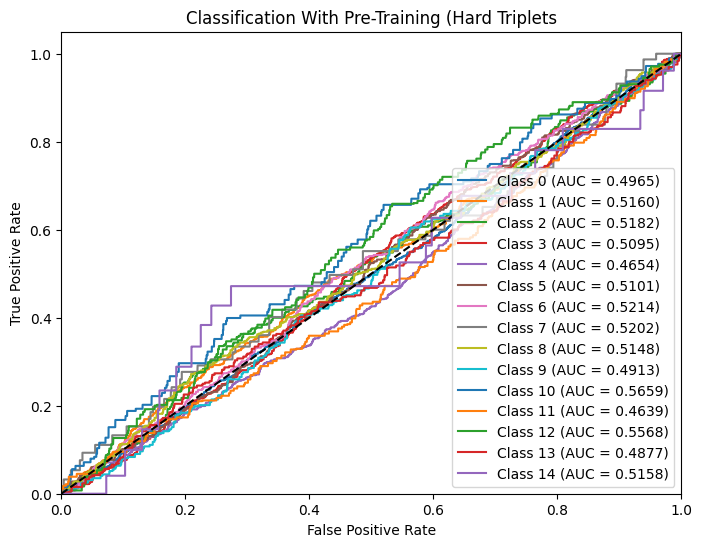

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(all_probs.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification With Pre-Training (Hard Triplets')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
top1_correct = 0
top5_correct = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        _, outputs = model(images)
        targ_labels = []
        for row in labels:
            lab = np.where(row == 1)[0]
            if lab.size == 0:
              targ_labels.append(0)
            else:
              targ_labels.append(lab[0]+1)

        targ_labels = torch.tensor(targ_labels)
        _, predicted = torch.max(outputs, 1)
        total += targ_labels.size(0)
        correct += (predicted == targ_labels).sum().item()
        _, top5_predicted = torch.topk(outputs, 5, dim=1)
        top1_correct += (predicted == targ_labels).sum().item()
        top5_correct += sum([targ_labels[i] in top5_predicted[i] for i in range(targ_labels.size(0))])
        
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
print('Top-1 Accuracy of the network on the test images: %d %%' % (
    100 * top1_correct / total))
print('Top-5 Accuracy of the network on the test images: %d %%' % (
    100 * top5_correct / total))

Accuracy of the network on the test images: 6 %
Top-1 Accuracy of the network on the test images: 6 %
Top-5 Accuracy of the network on the test images: 32 %
